In [1]:
import warnings
warnings.filterwarnings("ignore")

### Import Libraries

In [2]:
import pandas as pd
import re
import spacy
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from sacrebleu.metrics import TER

from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics.pairwise import cosine_similarity

### Load Dataset

In [3]:
# Load French Monolingual Dataset
sentences = []

with open('./Dataset/Monolingual/fra_news_2023_1M-sentences.txt', 'r', encoding='utf-8') as file:
    for line in file:
        if not line:
            continue

        parts = line.split('\t', 1)
        if len(parts) > 1:
            sentence = parts[1]
            sentences.append(sentence)

french_df = pd.DataFrame(sentences, columns=['Sentence'])
french_df

,Sentence
0,¤ Une coalition (BBY) composée de plus d’une c...
1,$Mais le groupe a aussi annoncé la suppression...
2,"$Toutefois, l’étude menée a également livré de..."
3,"€Dans les locaux d’Atem, à Solliès-Pont, les é..."
4,° 1.000.000 de dirhams hors taxes pour les mar...
...,...
999995,С’est son premier voyage à l’étranger depuis s...
999996,С’est un établissement d'enseignement supérieu...
999997,Сергей ГунеевAccéder à la base multimédiaVladi...
999998,"يا تونِسَ الأُنسِ يا خَضرا المَيادينِ », a écr..."


In [4]:
# Load English Monolingual Dataset
with open('./Dataset/Monolingual/news-commentary-v18.txt', 'r', encoding='utf-8') as file:
    sentences = file.readlines()

sentences = [sentence.strip() for sentence in sentences]
english_df = pd.DataFrame(sentences, columns=['Sentence'])
english_df

,Sentence
0,"$10,000 Gold?"
1,SAN FRANCISCO – It has never been easy to have...
2,"Lately, with gold prices up more than 300% ove..."
3,"Just last December, fellow economists Martin F..."
4,Wouldn’t you know it?
...,...
901593,"At the same time, Zuma’s revolutionary generat..."
901594,"In a region that reveres the elderly, Zuma’s a..."
901595,Three in ten South Africans are younger than 1...
901596,Somehow Zuma must find a way to honor his own ...


In [5]:
# Load German Monolingual Dataset
sentences = []

with open('./Dataset/Monolingual/deu-de_web-public_2019_10K-sentences.txt', 'r', encoding='utf-8') as file:
    for line in file:
        if not line:
            continue

        parts = line.split('\t', 1)
        if len(parts) > 1:
            sentence = parts[1]
            sentences.append(sentence)

german_df = pd.DataFrame(sentences, columns=['Sentence'])
german_df

,Sentence
0,¹ UNIDROIT ist das Internationale Institut für...
1,"""53 Euro!"", ruft der zurück.\n"
2,Aachen brach darunter aber nicht ein.\n
3,Ab 10 Euro: connect zeigt Ihnen Prepaid-Bundle...
4,Ab 11 Uhr ist das Haus geöffnet und ab 14.00 U...
...,...
9995,Zwischen den Fotos ist ein breiter Spalt gelas...
9996,Zwischendurch durften wir das warme Malzbier a...
9997,"Zwischen ihnen standen wieder die Kollegen, di..."
9998,"Zwischen Mittwoch, 19. Juni, 18.20 Uhr und Fre..."


### Preprocess Data

In [6]:
# Remove empty sentences if any
english_df = english_df[english_df['Sentence'].notna() & (english_df['Sentence'] != '')]
french_df = french_df[french_df['Sentence'].notna() & (french_df['Sentence'] != '')]
german_df = german_df[german_df['Sentence'].notna() & (german_df['Sentence'] != '')]

In [7]:
x = 2
french_df = french_df[:x]
english_df = english_df[:x]
german_df = german_df[:x]

In [8]:
NUM_LANGS = 3
MAX_SEQ_LEN = 50

lang_idx_mapping = {
    'english': 0,
    'french': 1,
    'german': 2,
}

In [9]:
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
    return sentence

In [10]:
english_df.loc[:, 'Sentence'] = english_df['Sentence'].apply(lambda x: preprocess_text(x))
french_df.loc[:, 'Sentence'] = french_df['Sentence'].apply(lambda x: preprocess_text(x))
german_df.loc[:, 'Sentence'] = german_df['Sentence'].apply(lambda x: preprocess_text(x))

In [11]:
def remerge_sent(sent):
    # merges tokens which are not separated by white-space
    # does this recursively until no further changes
    changed = True
    while changed:
        changed = False
        i = 0
        while i < sent.__len__() - 1:
            tok = sent[i]
            if not tok.whitespace_:
                ntok = sent[i + 1]
                # in-place operation.
                with sent.retokenize() as retokenizer:
                    retokenizer.merge(sent[i: i + 2])
                changed = True
            i += 1
    return sent

In [12]:
nlp_en = spacy.load('en_core_web_lg')
nlp_fr = spacy.load('fr_core_news_lg')
nlp_de = spacy.load('de_core_news_lg')

In [13]:
def tokenize_with_spacy(sentence, nlp):
    doc = nlp(sentence)
    spacy_sentence = remerge_sent(doc)
    return [token.text for token in spacy_sentence]

# Tokenize
english_df['Tokens'] = english_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_en))
french_df['Tokens'] = french_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_fr))
german_df['Tokens'] = german_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_fr))

In [14]:
# Drop sentences longer than 50 words
english_df = english_df[english_df['Tokens'].apply(len) <= MAX_SEQ_LEN]
french_df = french_df[french_df['Tokens'].apply(len) <= MAX_SEQ_LEN]
german_df = german_df[german_df['Tokens'].apply(len) <= MAX_SEQ_LEN]

In [15]:
# Find the minimum length across all three datasets
min_length = min(len(english_df), len(french_df), len(german_df))

# Slice each dataset to the minimum length
english_df = english_df.iloc[:min_length]
french_df = french_df.iloc[:min_length]
german_df = german_df.iloc[:min_length]

### Generate BERT Embeddings

We can use pre trained transformer models for generating embeddings for the tokens, we can use different versions of BERT for generation embeddings for French, German etc.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Load the pre-trained BERT tokenizer and model
# Load the fast version of the tokenizer

tokenizer_en = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model_en = AutoModel.from_pretrained('bert-base-uncased')
bert_model_en = bert_model_en.to(device)
vocab_embeddings_en = bert_model_en.embeddings.word_embeddings.weight  # shape: (vocab_size, 768)

tokenizer_fr = AutoTokenizer.from_pretrained('camembert-base', use_fast=True)
bert_model_fr = AutoModel.from_pretrained('camembert-base')
bert_model_fr = bert_model_fr.to(device)
vocab_embeddings_fr = bert_model_fr.embeddings.word_embeddings.weight  # shape: (vocab_size, 768)

tokenizer_de = AutoTokenizer.from_pretrained('bert-base-german-cased', use_fast=True)
bert_model_de = AutoModel.from_pretrained('bert-base-german-cased')
bert_model_de = bert_model_de.to(device)
vocab_embeddings_de = bert_model_de.embeddings.word_embeddings.weight  # shape: (vocab_size, 768)

In [18]:
# Retrieves BERT embeddings for a list of tokens using a fast tokenizer, enabling accurate aggregation of subword embeddings into their original token representations.
def get_bert_embeddings(tokens, tokenizer, bert_model):
    inputs = tokenizer(tokens, return_tensors='pt', is_split_into_words=True, padding=False, truncation=True)

    # Get BERT embeddings from the model
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Get the embeddings for each subword
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)
    # Get word_ids to align subword tokens with the original tokens
    word_ids = inputs.word_ids()

    # Aggregate subword embeddings back to their original tokens
    aggregated_embeddings = []
    current_token_embeddings = []

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if len(current_token_embeddings) > 0 and word_id != word_ids[idx - 1]:
            aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))
            current_token_embeddings = []
        current_token_embeddings.append(token_embeddings[idx])
    
    if len(current_token_embeddings) > 0:
        aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))

    return torch.stack(aggregated_embeddings)

In [19]:
# Function to generate BERT embeddings for dataFrame
def generate_embeddings(df, tokenizer, bert_model):
    embeddings_list = []
    for _, row in df.iterrows():
        tokenized_sentence = row['Tokens']
        embeddings = get_bert_embeddings(tokenized_sentence, tokenizer, bert_model)
        embeddings_list.append(embeddings)
    return embeddings_list

In [20]:
def generate_padded_embeddings(df, embedding_list, max_len=MAX_SEQ_LEN):
    # Pad the sequences using pad_sequence. It will pad them to the length of the longest sentence.
    padded_embeddings = pad_sequence(embedding_list, batch_first=True, padding_value=0)
    
    # Truncate the sequences if they are longer than max_len
    if padded_embeddings.size(1) > max_len:
        padded_embeddings = padded_embeddings[:, :max_len, :]
    # If sequences are shorter than max_len, pad them manually
    elif padded_embeddings.size(1) < max_len:
        padding_size = max_len - padded_embeddings.size(1)
        padded_embeddings = F.pad(padded_embeddings, (0, 0, 0, padding_size), value=0)
    
    # Assign the padded embeddings to the dataframe
    df['Embeddings'] = [padded_embeddings[i] for i in range(padded_embeddings.shape[0])]
    print(f"Padded Embeddings Shape: {padded_embeddings.shape}")

In [21]:
english_embeddings = generate_embeddings(english_df, tokenizer_en, bert_model_en)
english_embeddings[0].shape

torch.Size([2, 768])

In [22]:
generate_padded_embeddings(english_df, english_embeddings)

Padded Embeddings Shape: torch.Size([2, 50, 768])


In [23]:
french_embeddings = generate_embeddings(french_df, tokenizer_fr, bert_model_fr)
french_embeddings[0].shape

torch.Size([30, 768])

In [24]:
generate_padded_embeddings(french_df, french_embeddings)

Padded Embeddings Shape: torch.Size([2, 50, 768])


In [25]:
german_embeddings = generate_embeddings(german_df, tokenizer_de, bert_model_de)
german_embeddings[0].shape

torch.Size([15, 768])

In [26]:
generate_padded_embeddings(german_df, german_embeddings)

Padded Embeddings Shape: torch.Size([2, 50, 768])


## Denoising Auto Encoding (DAE)

Noise is added to make sure that self auto encoding mechanism is not just returning the same sequence of words, and rather learns the structure of the sentence, otherwise for a random sequence of words also it will return the same output.

In [27]:
def apply_word_dropout(sentence, pwd=0.1, padding_embedding=None):
    noisy_sentence = []
    drop_count = 0

    for word in sentence:
        if random.random() > pwd:
            noisy_sentence.append(word)
        else:
            drop_count += 1

    if padding_embedding is None:
        padding_embedding = torch.zeros_like(sentence[0]) 

    noisy_sentence.extend([padding_embedding] * drop_count)
    noisy_sentence_tensor = torch.stack(noisy_sentence)

    return noisy_sentence_tensor

In [28]:
def apply_sentence_shuffling(sentence, k=3, alpha=0.5):
    n = sentence.size(0)

    # Generating random permutation vector q
    q = torch.arange(n).float() + torch.rand(n) * alpha  # Slightly perturb the indices
    _, permuted_indices = torch.sort(q)  # Sorting to get the permutation

    # Apply the shuffle, respecting the condition |σ(i) - i| <= k
    for i in range(n):
        if abs(permuted_indices[i] - i) > k:
            permuted_indices[i] = i 
    
    # Shuffle sentence according to the permuted indices
    shuffled_sentence = sentence[permuted_indices]
    
    return shuffled_sentence

In [29]:
def apply_noise(x, pwd=0.1, k=3, alpha=0.5):
    if isinstance(x, list):
        x = torch.tensor(x)

    # Apply word dropout
    x_noisy = apply_word_dropout(x, pwd)
    
    # Apply sentence shuffling
    x_noisy = apply_sentence_shuffling(x_noisy, k, alpha)
    
    return x_noisy

#### Encoder Decoder With Attention

This is mainly used for longer sentences. As the sentence gets longer, the context vector $(z)$ passed as the first input to the decoder gets diminished or forgotten, and the decoder loses its attention or focus on the main parts of the sequence, causing a drop in the BLEU score.

#### Decoder

The decoder generates the target sentence by iteratively producing each word $y_i$, based on:

$$
p(y_i \mid y_1, \dots, y_{i-1}, x) = g(y_{i-1}, s_i, c_i)
$$

Where:

- $y_i$ is the target word at time step $i$,
- $s_i$ is the hidden state of the decoder LSTM at time step $i$,
- $c_i$ is the context vector that summarizes the relevant information from the encoder.

---

#### Decoder Hidden State Update

The hidden state of the decoder at each time step $i$ is computed by an RNN / LSTM update. The state is conditioned on the previous hidden state $(s_{i-1})$, the previously generated word $(y_{i-1})$, and the context vector $(c_i)$. The context vector contains information from the encoder and helps the decoder focus on the most relevant parts of the source sentence.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

Where:
- $s_i$ is the decoder's hidden state at time step $i$,
- $s_{i-1}$ is the hidden state from the previous time step,
- $y_{i-1}$ is the previously generated target word,
- $c_i$ is the context vector at time step $i$.

---

#### Context Vector

The context vector $c_i$ is a weighted sum of the encoder's hidden states (annotations). It reflects the parts of the source sentence that the decoder should focus on when generating the target word $y_i$. Each hidden state $h_j$ from the encoder is weighted by an attention weight $\alpha_{ij}$, which indicates how much attention to pay to that part of the input sentence at time step $i$.

$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j
$$

Where:
- $h_j$ is the encoder hidden state at position $j$,
- $\alpha_{ij}$ is the attention weight for position $j$ at decoding time step $i$,
- $T_x$ is the length of the input sequence.

---

#### Attention Weights

The attention weight $\alpha_{ij}$ represents how much focus the decoder should place on the $j$-th hidden state of the encoder when generating the $i$-th target word. These attention weights are computed using a softmax function, which ensures that the weights sum to 1 across all positions in the input sequence. This mechanism allows the decoder to pay varying degrees of attention to different parts of the input sequence at each step.

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}
$$

Where:
- $e_{ij}$ is the alignment score for the $j$-th input word and the $i$-th target word,
- The denominator sums over all alignment scores for input positions $k$, normalizing the attention weights.

---

#### Alignment Score

The alignment score $e_{ij}$ is computed by a feedforward neural network, known as the **alignment model**. It measures how well the decoder's previous hidden state $s_{i-1}$ aligns with the encoder's hidden state $h_j$. This score helps decide which parts of the source sentence are most relevant when predicting the next target word.

$$
e_{ij} = a(s_{i-1}, h_j)
$$

Where:
- $s_{i-1}$ is the decoder hidden state at time step $i-1$,
- $h_j$ is the encoder hidden state at position $j$,
- $a$ is the alignment model, which can be a simple feedforward network.

### BiLSTM Encoder

Generates sequence of hidden (latent) states for a given sequence of input embeddings (src/tgt language).

In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, lang_embed_dim=32):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim + lang_embed_dim, hidden_dim, bidirectional=True, batch_first=True, num_layers=num_layers)
        
        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.activation = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        # Language embedding layer
        self.lang_embedding = nn.Embedding(NUM_LANGS, lang_embed_dim)  

    def forward(self, inputs, lang_idx):
        # Get language embedding
        lang_emb = self.lang_embedding(lang_idx).unsqueeze(1).expand(-1, inputs.size(1), -1)

        # Concatenate the language embedding with the input embeddings
        inputs_with_lang = torch.cat((inputs, lang_emb), dim=-1)

        lstm_out, _ = self.lstm(inputs_with_lang)  # (batch_size, seq_len, hidden_dim * 2)
        
        # Apply dropout and batch normalization
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.batch_norm(lstm_out.transpose(1, 2)).transpose(1, 2)
        
        # Pass through fully connected layers
        fc1_output = self.activation(self.fc1(lstm_out))  # (batch_size, seq_len, hidden_dim)
        fc2_output = self.activation(self.fc2(fc1_output))  # (batch_size, seq_len, hidden_dim // 2)
        latent_output = self.fc3(fc2_output)  # (batch_size, seq_len, output_dim)
        
        # fc1_output has shape 300*1
        return fc1_output, latent_output

#### LSTM Decoder

Generates sequence of words in a (src/tgt) language based on the previous hidden state of the decoder, the current word (hidden state from the encoder), and a context vector given by a weighted sum over the encoder output states.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        self.hidden_dim = hidden_dim
        
        # Attention mechanism to compute attention weights
        # Concatenate hidden state and encoder outputs, and project to hidden_dim
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)  # Input dim = 2 * hidden_dim, Output = hidden_dim
        self.v = nn.Parameter(torch.rand(hidden_dim))      # Attention vector for scoring

    def forward(self, hidden, encoder_outputs):
        """
        Compute the attention weights and context vector.
        
        Args:
            hidden: The hidden state of the decoder (batch_size, hidden_dim)
            encoder_outputs: The outputs from the encoder (batch_size, seq_len, hidden_dim)
        
        Returns:
            context: The context vector (batch_size, hidden_dim)
        """
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        hidden_dim = encoder_outputs.size(2)

        # Expand hidden state to match the sequence length
        hidden_expanded = hidden.unsqueeze(1).expand(batch_size, seq_len, hidden_dim)  # (batch_size, seq_len, hidden_dim)

        # Concatenate hidden state and encoder outputs along the last dimension
        concatenated = torch.cat((hidden_expanded, encoder_outputs), dim=2)  # (batch_size, seq_len, 2 * hidden_dim)

        # Pass through the attention network
        energy = torch.tanh(self.attn(concatenated))  # (batch_size, seq_len, hidden_dim)

        # Transpose energy to prepare for batch matrix multiplication
        energy = energy.transpose(1, 2)  # (batch_size, hidden_dim, seq_len)

        # Repeat v to match the batch size (for each batch, we use the same attention vector)
        v_expanded = self.v.repeat(batch_size, 1).unsqueeze(1)  # (batch_size, 1, hidden_dim)

        # Compute attention scores using batch matrix multiplication
        attn_weights = torch.bmm(v_expanded, energy).squeeze(1)  # (batch_size, seq_len)

        # Normalize attention weights using softmax
        attn_weights = F.softmax(attn_weights, dim=1)  # (batch_size, seq_len)

        # Compute the context vector as the weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_dim)

        return context

In [32]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=3, lang_embed_dim=32):
        super(Decoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer for decoding
        # Takes input as the context vector of hidden_dim and output from the encoder of latent_dim
        # Outputs a hidden state of hidden_dim
        self.lstm = nn.LSTM(latent_dim + hidden_dim + lang_embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # Attention mechanism
        self.attn = Attention(hidden_dim)

        # Fully connected layer to output the prediction
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

        # Language embedding layer
        self.lang_embedding = nn.Embedding(NUM_LANGS, lang_embed_dim)

    def forward(self, latent_vectors, encoder_outputs, hidden, lang_idx):
        """
        Decoder forward pass with attention mechanism.

        Args:
            latent_vectors: The latent vectors from the encoder (batch_size, seq_len, latent_dim), output given by bidirectional LSTM encoder after summarizing (abstracting) the input sentence, that is passing through the fc layers.
            They will be used as input for decoder LSTM, for finding the target word.

            encoder_outputs: The encoder outputs (batch_size, seq_len, latent_dim), output given by bidirectional LSTM encoder of dim 300.
            They will by used for finding the attention weights and context vector.
            
            hidden: The hidden state from the previous time step (num_layers, batch_size, hidden_dim)
            
        Returns:
            outputs: The generated output sequence (batch_size, seq_len, output_dim)
            hidden: The updated hidden state (num_layers, batch_size, hidden_dim)
        """
        batch_size = latent_vectors.size(0)
        seq_len = latent_vectors.size(1)

        # Get language embedding
        lang_emb = self.lang_embedding(lang_idx).unsqueeze(1).expand(-1, latent_vectors.size(1), -1)

        # Initialize the output tensor
        outputs = torch.zeros(batch_size, seq_len, self.fc_out.out_features).to(latent_vectors.device)

        # Iterate through the sequence to generate each word
        for t in range(seq_len):
            # Get attention weights and context vector
            # hidden[0][-1] gives the previous hidden state, need to take hidden[0] as hidden is a tuple (h,c)
            context = self.attn(hidden[0][-1], encoder_outputs)

            # Concatenate the context vector, latent vector, and language embedding
            lstm_input = torch.cat((context, latent_vectors[:, t], lang_emb[:, t]), dim=1).unsqueeze(1)

            # Pass through the LSTM
            lstm_out, hidden = self.lstm(lstm_input, hidden)  # lstm_out: (batch_size, 1, hidden_dim)
            lstm_out = self.dropout(lstm_out)

            # Predict the next word
            outputs[:, t] = self.fc_out(lstm_out.squeeze(1))

        return outputs, hidden

    def init_hidden(self, batch_size):
        """ Initialize hidden state and cell state for LSTM """
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return (h0, c0)

### Training the DAE Model

In [33]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 2
NUM_LSTM_LAYERS = 3
LEARNING_RATE = 0.0003
LANG_DIM = 32

# Encoder
ENCODER_INPUT_DIM = 768 
ENCODER_HIDDEN_DIM = 300
ENCODER_OUTPUT_DIM = 100 

# Decoder
DECODER_OUTPUT_DIM = ENCODER_INPUT_DIM
DECODER_LATENT_DIM = ENCODER_OUTPUT_DIM
DECODER_HIIDEN_DIM = 300

Language index has been added for each sentence, as we are using ```same encoder and decoder``` instance for source and target languages, i.e ```weights are being shared```, so encoder takes in the language index and creates a language embedding which is appended to the input word embedding, also the decoder takes the output generated by encoder, context vector and also the langauge vector to produce output sequence in the given language.

In [34]:
# x and y are same because of auto-encoding
english_dataset = TensorDataset(
    torch.stack(english_df['Embeddings'].tolist()),
    torch.stack(english_df['Embeddings'].tolist()),
    torch.tensor([lang_idx_mapping['english']] * len(english_df))
)
english_loader = DataLoader(
    english_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

french_dataset = TensorDataset(
    torch.stack(french_df['Embeddings'].tolist()),
    torch.stack(french_df['Embeddings'].tolist()),
    torch.tensor([lang_idx_mapping['french']] * len(french_df))
)
french_loader = DataLoader(
    french_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

german_dataset = TensorDataset(
    torch.stack(german_df['Embeddings'].tolist()),
    torch.stack(german_df['Embeddings'].tolist()),
    torch.tensor([lang_idx_mapping['german']] * len(german_df))
)
german_loader = DataLoader(
    german_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Combine both datasets
combined_dataset = torch.utils.data.ConcatDataset([english_dataset, french_dataset, german_dataset])
combined_loader = DataLoader(
    combined_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [35]:
# Initialize models

# english french
encoder_model_1 = Encoder(
    ENCODER_INPUT_DIM,
    ENCODER_HIDDEN_DIM, 
    ENCODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)
decoder_model_1 = Decoder(
    DECODER_LATENT_DIM,
    DECODER_HIIDEN_DIM,
    DECODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)

# english german
encoder_model_2 = Encoder(
    ENCODER_INPUT_DIM,
    ENCODER_HIDDEN_DIM, 
    ENCODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)
decoder_model_2 = Decoder(
    DECODER_LATENT_DIM,
    DECODER_HIIDEN_DIM,
    DECODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)

# german french
encoder_model_3 = Encoder(
    ENCODER_INPUT_DIM,
    ENCODER_HIDDEN_DIM, 
    ENCODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)
decoder_model_3 = Decoder(
    DECODER_LATENT_DIM,
    DECODER_HIIDEN_DIM,
    DECODER_OUTPUT_DIM,
    NUM_LSTM_LAYERS,
)

In [36]:
# Set the models to train mode
encoder_model_1.train()
decoder_model_1.train()

encoder_model_2.train()
decoder_model_2.train()

encoder_model_3.train()
decoder_model_3.train()

Decoder(
  (lstm): LSTM(432, 300, num_layers=3, batch_first=True)
  (attn): Attention(
    (attn): Linear(in_features=600, out_features=300, bias=True)
  )
  (fc_out): Linear(in_features=300, out_features=768, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (lang_embedding): Embedding(3, 32)
)

In [37]:
# Initialize optimizer (Adam)
enc_dec_optimizer_1 = optim.Adam(
    list(encoder_model_1.parameters()) + list(decoder_model_1.parameters()), 
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

enc_dec_optimizer_2 = optim.Adam(
    list(encoder_model_2.parameters()) + list(decoder_model_2.parameters()), 
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

enc_dec_optimizer_3 = optim.Adam(
    list(encoder_model_3.parameters()) + list(decoder_model_3.parameters()), 
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

In [38]:
# Loss function (Cosine Loss)
def cosine_similarity_loss(predictions, targets, pad_idx=0): 
    # Flatten the predictions and targets
    predictions = predictions.view(-1, predictions.size(-1))  # (batch_size * seq_len, embedding_dim)
    targets = targets.view(-1, targets.size(-1))  # (batch_size * seq_len, embedding_dim)

    # Create a mask to exclude padded positions
    mask = (targets.sum(dim=-1) != pad_idx).float()  # (batch_size * seq_len,)

    # Compute the cosine similarity between the predictions and targets
    cos_sim = F.cosine_similarity(predictions, targets, dim=-1)  # (batch_size * seq_len,)
    loss = (1 - cos_sim) * mask  # Apply mask to exclude padding positions
    loss = loss.sum() / mask.sum()  # Average the loss over non-padding tokens

    return loss

In [39]:
def plot_loss(losses):
    epochs = np.arange(1, len(losses) + 1)
    fig, ax = plt.subplots(figsize=(6, 4))  

    norm = plt.Normalize(vmin=min(losses), vmax=max(losses))
    colors = plt.cm.cividis(norm(losses)) 

    for i in range(len(epochs) - 1):
        alpha_value = max(0.3, 0.8 - i * 0.02) 
        ax.plot(epochs[i:i+2], losses[i:i+2], color=colors[i], alpha=alpha_value, linewidth=2)

    ax.fill_between(epochs, losses, color='lightblue', alpha=0.3)

    ax.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)

    sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
    sm.set_array([]) 
    fig.colorbar(sm, ax=ax, label='Loss Intensity')

    plt.tight_layout()
    plt.show()

In [40]:
# Function for training the model
def train_dae(encoder_model, decoder_model, optimizer, data_loader, clip, pad_idx=0):
    all_losses = []

    for epoch in range(NUM_EPOCHS):
        encoder_model.train()
        decoder_model.train()

        epoch_loss = 0
        for batch in data_loader:
            inputs = batch[0].to(device)  # BERT embeddings
            targets = batch[1].to(device)  # Same because of autoencoding
            lang_idx = batch[2].to(device)  # Get language index for each sentence
            
            # Add noise to inputs and stack them into a tensor
            noisy_inputs = torch.stack([apply_noise(sentence) for sentence in inputs]).to(device)

            optimizer.zero_grad()

            # Forward pass through encoder
            encoder_outputs, latent_vectors = encoder_model(noisy_inputs, lang_idx)
            
            # Initialize decoder hidden state for each batch
            hidden = decoder_model.init_hidden(inputs.size(0))  
            
            # Decoder forward pass with attention
            outputs, hidden = decoder_model(latent_vectors, encoder_outputs, hidden, lang_idx)

            # Compute the loss
            loss = cosine_similarity_loss(outputs, targets, pad_idx)

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(encoder_model.parameters(), clip)
            torch.nn.utils.clip_grad_norm_(decoder_model.parameters(), clip)

            # Optimizer step
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(data_loader)
        all_losses.append(avg_epoch_loss)

        # Print the loss for each epoch
        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}')
    
    plot_loss(all_losses)

#### Training DAE

In [41]:
# # Train DAE Dataset
# train_dae(
#     encoder_model,
#     decoder_model,
#     enc_dec_optimizer,
#     combined_loader,
#     clip=1.0,
# )

### Converting Embeddings generated by Decoder to Sentence

In [42]:
def get_closest_token_from_vocab(embedding, vocab_embeddings):
    # Find the closest token from the vocabulary for a given embedding.
    similarities = F.cosine_similarity(embedding, vocab_embeddings, dim=1)
    closest_token_idx = torch.argmax(similarities)
    return closest_token_idx.item()

In [43]:
def embeddings_to_text(output_embeddings, tokenizer, vocab_embeddings):

    batch_size, seq_len, embedding_dim = output_embeddings.size()
    tokens = []
    
    # Iterate over each sequence in the batch
    for i in range(batch_size):
        sequence_tokens = []
        
        # Iterate over each embedding in the sequence
        for j in range(seq_len):
            embedding = output_embeddings[i, j]  # Shape: (embedding_dim,)
            token_idx = get_closest_token_from_vocab(embedding, vocab_embeddings)
            token = tokenizer.convert_ids_to_tokens(token_idx)
            sequence_tokens.append(token)
        
        sentence = tokenizer.convert_tokens_to_string(sequence_tokens)
        tokens.append(sentence)
    
    return tokens

In [44]:
def generate_text_using_dae(df, tokenizer, vocab_embeddings, lang_idx, encoder_model, decoder_model):
    inputs = torch.stack([sentence for sentence in df['Embeddings']]).to(device)
    lang_idx_tensor = torch.tensor([lang_idx] * len(df)).to(device)

    encoder_outputs, latent_vectors = encoder_model(inputs, lang_idx_tensor)

    # Initialize decoder hidden state for each batch
    hidden = decoder_model.init_hidden(len(df['Embeddings']))  

    # Decoder forward pass with attention
    outputs, hidden = decoder_model(latent_vectors, encoder_outputs, hidden, lang_idx_tensor)

    generated_text = embeddings_to_text(outputs, tokenizer, vocab_embeddings)

    def clean_output(text):
        return ' '.join(
            [token for token in text.split() if token not in [
                '[SEP]', '[SEP].', '[MASK]', '[CLS]'
            ]]
        )

    # Clean the generated text
    cleaned_text = [clean_output(sentence) for sentence in generated_text]
    for sentence in cleaned_text:
        print("Generated Sentence:", sentence)

In [45]:
# Generate text for english
# generate_text_using_dae(english_df, tokenizer_en, vocab_embeddings_en, lang_idx_mapping['english'], encoder_model_1, decoder_model_1)

In [46]:
# Generate text for french
# generate_text_using_dae(french_df, tokenizer_fr, vocab_embeddings_fr, lang_idx_mapping['french'], encoder_model_3, decoder_model_3)

In [47]:
# Generate text for German
# generate_text_using_dae(german_df, tokenizer_de, vocab_embeddings_de, lang_idx_mapping['german'], encoder_model_2, decoder_model_2)

### Word by Word Translation

Initial model, for naive word to word translation of sentences using a parallel dictionary learnt in an unsupervised way

In [48]:
# English French
source_loader1 = english_loader
target_loader1 = french_loader
source_vocab1 = vocab_embeddings_en
target_vocab1 = vocab_embeddings_fr

# English German
source_loader2 = english_loader
target_loader2 = german_loader
source_vocab2 = vocab_embeddings_en
target_vocab2 = vocab_embeddings_de

# French German
source_loader3 = french_loader
target_loader3 = german_loader
source_vocab3 = vocab_embeddings_fr
target_vocab3 = vocab_embeddings_de

In [49]:
def initialize_word_by_word_model(source_embeddings, target_embeddings, source_vocab, target_vocab, num_iterations=NUM_EPOCHS):    
    # Normalize embeddings
    source_embeddings = source_embeddings / np.linalg.norm(source_embeddings, axis=1, keepdims=True)
    target_embeddings = target_embeddings / np.linalg.norm(target_embeddings, axis=1, keepdims=True)

    # Convert embeddings to torch tensors
    X = torch.tensor(source_embeddings, dtype=torch.float32).to(device)
    Y = torch.tensor(target_embeddings, dtype=torch.float32).to(device)

    # Ensure that the dimensionality of W matches the original embeddings
    embedding_dim = X.shape[2]  # Original dimensionality of the embeddings
    W = torch.nn.Linear(embedding_dim, embedding_dim, bias=False).to(device)  # Keep the embedding size the same
    torch.nn.init.eye_(W.weight)  # Start with identity matrix
    optimizer = torch.optim.Adam(W.parameters(), lr=0.1)
    
    # Discriminator model
    discriminator = torch.nn.Sequential(
        torch.nn.Linear(embedding_dim, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 1),
        torch.nn.Sigmoid()
    ).to(device)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.1)

    # Adversarial Training Loop
    for epoch in range(num_iterations):
        # Train discriminator
        discriminator_optimizer.zero_grad()
        WX = W(X)
        src_preds = discriminator(WX)
        tgt_preds = discriminator(Y)
        
        # Labels: 1 for source, 0 for target
        src_labels = torch.ones(WX.size(0), WX.size(1), 1).to(device)  # [10, 50, 1] for source
        tgt_labels = torch.zeros(Y.size(0), Y.size(1), 1).to(device)  # [10, 50, 1] for target
    
        disc_loss = (
            torch.nn.functional.binary_cross_entropy(src_preds, src_labels) +
            torch.nn.functional.binary_cross_entropy(tgt_preds, tgt_labels)
        )
        disc_loss.backward()
        discriminator_optimizer.step()
        
        # Train mapping (W)
        optimizer.zero_grad()
        WX = W(X)
        src_preds = discriminator(WX)
        
        # Reverse the labels for adversarial training
        mapping_loss = torch.nn.functional.binary_cross_entropy(src_preds, tgt_labels)
        mapping_loss.backward()
        optimizer.step()
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Discriminator Loss: {disc_loss.item():.4f}, Mapping Loss: {mapping_loss.item():.4f}")

    # Procrustes Refinement
    with torch.no_grad():
        # Compute SVD of Y^T * W * X
        # Ensure that we are doing matrix multiplication between embeddings in compatible shapes
        A = Y.view(-1, Y.size(-1)).T @ W(X).view(-1, W(X).size(-1))  # Flatten the dimensions for multiplication
        U, _, V = torch.svd(A)
        W.weight.data = (U @ V.T).to(device)  # Update W to enforce orthogonality

    
    # Detach WX before converting to numpy
    WX_flat = WX.detach().view(-1, WX.size(-1)).numpy()  # Shape: [500, 768] if there are 500 words
    target_embeddings_flat = target_embeddings.reshape(-1, target_embeddings.shape[-1])  # Shape: [500, 768]

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(WX_flat, target_embeddings_flat)

    # Mapping from source to target
    source_to_target_mapping = {}
    for i, source_word in enumerate(source_vocab):  # Iterate over source_vocab
        if i < similarity_matrix.shape[0]:  # Ensure index is within bounds
            best_match_idx = np.argmax(similarity_matrix[i])
            target_word = target_vocab[best_match_idx]
            source_to_target_mapping[source_word] = target_word

    # Mapping from target to source
    target_to_source_mapping = {}
    for j, target_word in enumerate(target_vocab):  # Iterate over target_vocab
        if j < similarity_matrix.shape[0]:  # Ensure index is within bounds
            best_match_idx = np.argmax(similarity_matrix[:, j])
            source_word = source_vocab[best_match_idx]
            target_to_source_mapping[target_word] = source_word

    return source_to_target_mapping, target_to_source_mapping

In [50]:
def compute_csls(source_embeddings, target_embeddings, k=10):
    """
    Compute CSLS (Cross Domain Similarity Local Scaling) similarity between source and target embeddings.
    Parameters:
    - source_embeddings: Source embeddings matrix (N x D).
    - target_embeddings: Target embeddings matrix (M x D).
    - k: Number of neighbors to consider for local scaling.
    Returns:
    - CSLS similarity matrix (N x M).
    """
    # Compute pairwise cosine similarities
    similarity_matrix = cosine_similarity(source_embeddings, target_embeddings)

    # Compute mean similarity for source and target neighborhoods
    r_source = np.mean(np.sort(similarity_matrix, axis=1)[:, -k:], axis=1)
    r_target = np.mean(np.sort(similarity_matrix, axis=0)[-k:, :], axis=0)

    # Adjust similarities using CSLS
    csls_matrix = 2 * similarity_matrix - r_source[:, np.newaxis] - r_target[np.newaxis, :]

    return csls_matrix

In [51]:
def apply_word_by_word_translation(
    source_inputs,
    source_to_target_mapping,
    device="cpu"
):
    """
    Translates sentences word-by-word using a source-to-target embedding mapping.

    Parameters:
    - source_inputs (list of lists): Batch of tokenized sentences.
    - source_to_target_mapping (dict): Mapping of source words to target embeddings.
    - device (str): Device to perform computation on ("cpu" or "cuda").

    Returns:
    - Tensor of shape [batch_size, seq_len, embedding_size].
    """
    # Extract target embeddings from the mapping (assuming all source embeddings have the same size)
    target_embeddings = torch.stack(list(source_to_target_mapping.values())).to(device)  # Shape: [vocab_size, embedding_size]
    
    # Get the embedding size dynamically
    embedding_size = target_embeddings.size(1)  # Size of the second dimension, the embedding size

    translated_sentences = []
    for sentence in source_inputs:
        translated_sentence = []
        for word in sentence:
            if word in source_to_target_mapping:
                # Exact match in the mapping, use the target embedding
                translated_word = source_to_target_mapping[word].to(device)
            else:
                # Handle missing words by finding the closest key in the source_to_target_mapping
                similarity_scores = {}
                # Get all keys in the dictionary
                for key, target_embedding in source_to_target_mapping.items():
                    # Get the embedding of the current word from the source dictionary
                    word_embedding = word 

                    # Ensure no gradient tracking when converting to numpy
                    word_embedding = word_embedding.detach()

                    # Calculate cosine similarity between the word embedding and the target embeddings
                    similarity_scores[key] = cosine_similarity(
                        word_embedding.unsqueeze(0).cpu().numpy(),  # Word embedding to compare
                        key.unsqueeze(0).detach().cpu().numpy()  # Target word embedding to compare
                    )
                
                # Get the closest word key based on similarity
                closest_key = max(similarity_scores, key=similarity_scores.get)
                translated_word = source_to_target_mapping[closest_key].to(device)
                
            translated_sentence.append(translated_word)

        # Stack tensors for the translated sentence
        translated_sentences.append(torch.stack(translated_sentence))

    # Pad sentences to the same length
    max_len = max(len(sentence) for sentence in translated_sentences)
    padded_sentences = [
        torch.cat([sentence, torch.zeros(max_len - len(sentence), embedding_size).to(device)], dim=0)
        if len(sentence) < max_len else sentence
        for sentence in translated_sentences
    ]

    # Combine all sentences into a batch tensor
    batch_tensor = torch.stack(padded_sentences)  # Shape: [batch_size, seq_len, embedding_size]
    return batch_tensor

In [52]:
def update_word_by_word_model(encoder_model, source_loader, target_loader, source_vocab, target_vocab):
    """
    Updates the word-by-word translation model using encoder outputs.
    Parameters:
    - encoder_model: Trained encoder model.
    - source_loader: DataLoader for the source language.
    - target_loader: DataLoader for the target language.
    - source_vocab: List of unique words in the source language.
    - target_vocab: List of unique words in the target language.
    Returns:
    - Two bilingual dictionaries:
      1. Source-to-target mapping
      2. Target-to-source mapping
    """
    encoder_model.eval()

    # Step 1: Extract Latent Representations for Source and Target (Word-Level)
    source_embeddings = []
    target_embeddings = []

    with torch.no_grad():
        for source_batch in source_loader:
            source_inputs = source_batch[0].to(device)
            source_lang_idx = source_batch[2].to(device)
            _, source_latents = encoder_model(source_inputs, source_lang_idx)
            
            # Reshape embeddings from [batch_size, seq_len, embedding_dim] to [num_words, embedding_dim]
            # Flatten the batch dimension and sequence length
            source_latents = source_latents.view(-1, source_latents.size(-1))  # shape: [num_source_words, embedding_dim]
            source_embeddings.append(source_latents.cpu().numpy())

        for target_batch in target_loader:
            target_inputs = target_batch[0].to(device)
            target_lang_idx = target_batch[2].to(device)
            _, target_latents = encoder_model(target_inputs, target_lang_idx)
            
            # Reshape embeddings from [batch_size, seq_len, embedding_dim] to [num_words, embedding_dim]
            target_latents = target_latents.view(-1, target_latents.size(-1))  # shape: [num_target_words, embedding_dim]
            target_embeddings.append(target_latents.cpu().numpy())

    # Concatenate embeddings across all batches
    source_embeddings = np.concatenate(source_embeddings, axis=0)  # shape: [num_source_words, embedding_dim]
    target_embeddings = np.concatenate(target_embeddings, axis=0)  # shape: [num_target_words, embedding_dim]

    # Normalize embeddings for cosine similarity
    source_embeddings = source_embeddings / np.linalg.norm(source_embeddings, axis=1, keepdims=True)
    target_embeddings = target_embeddings / np.linalg.norm(target_embeddings, axis=1, keepdims=True)

    # Step 2: Compute Similarity Matrix (Word-Level)
    similarity_matrix = compute_csls(source_embeddings, target_embeddings)

    # Step 3: Find Nearest Neighbors (Source to Target)
    source_to_target_mapping = {}
    for i, src_word in enumerate(source_vocab):
        if i >= similarity_matrix.shape[0]:
            continue
        best_match_idx = np.argmax(similarity_matrix[i])  # Find best match in target
        # Only map if a match exists
        if best_match_idx < len(target_vocab):
            source_to_target_mapping[src_word] = target_vocab[best_match_idx]

    # Step 4: Find Nearest Neighbors (Target to Source)
    target_to_source_mapping = {}
    for j, tgt_word in enumerate(target_vocab):
        if j >= similarity_matrix.shape[1]:
            continue
        best_match_idx = np.argmax(similarity_matrix[:, j])  # Find best match in source
        # Only map if a match exists
        if best_match_idx < len(source_vocab):
            target_to_source_mapping[tgt_word] = source_vocab[best_match_idx]

    return source_to_target_mapping, target_to_source_mapping

In [53]:
def generate_word_by_word_mapping(source_loader, target_loader, source_vocab, target_vocab):
    # Extract embeddings without encoder
    source_embeddings = []
    target_embeddings = []

    for source_batch, target_batch in zip(source_loader, target_loader):
        source_inputs = source_batch[0] 
        target_inputs = target_batch[0]
        
        source_embeddings.append(source_inputs.numpy())
        target_embeddings.append(target_inputs.numpy())

    # Convert lists to numpy arrays for further processing
    source_embeddings = np.vstack(source_embeddings)
    target_embeddings = np.vstack(target_embeddings)

    # Pass embeddings directly to initialize the word-by-word mapping model
    source_to_target_mapping, target_to_source_mapping = initialize_word_by_word_model(
        source_embeddings, target_embeddings, source_vocab, target_vocab
    )

    return source_to_target_mapping, target_to_source_mapping

In [54]:
source_to_target_mapping1, target_to_source_mapping1 = generate_word_by_word_mapping(source_loader1, target_loader1, source_vocab1, target_vocab1)

Epoch 0, Discriminator Loss: 1.3785, Mapping Loss: 9.8671


In [55]:
source_to_target_mapping2, target_to_source_mapping2 = generate_word_by_word_mapping(source_loader2, target_loader2, source_vocab2, target_vocab2)

Epoch 0, Discriminator Loss: 1.3853, Mapping Loss: 19.7102


In [56]:
source_to_target_mapping3, target_to_source_mapping3 = generate_word_by_word_mapping(source_loader3, target_loader3, source_vocab3, target_vocab3)

Epoch 0, Discriminator Loss: 1.3908, Mapping Loss: 38.9898


### Discriminator

In [57]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid output for binary classification
        return x

In [58]:
disc_model_1 = Discriminator(ENCODER_OUTPUT_DIM)
disc_optimizer_1 = optim.Adam(disc_model_1.parameters(), lr=LEARNING_RATE)

disc_model_2 = Discriminator(ENCODER_OUTPUT_DIM)
disc_optimizer_2 = optim.Adam(disc_model_2.parameters(), lr=LEARNING_RATE)

disc_model_3 = Discriminator(ENCODER_OUTPUT_DIM)
disc_optimizer_3 = optim.Adam(disc_model_3.parameters(), lr=LEARNING_RATE)

In [59]:
def train_cross_domain_non_parallel(
        encoder_model, decoder_model, disc_model, enc_dec_optimizer, disc_optimizer,
        source_loader, target_loader, source_vocab, target_vocab,
        source_to_target_mapping, target_to_source_mapping,
        clip, lambda_auto=1.0, lambda_cd=1.0, lambda_adv=1.0, pad_idx=0,
    ):
    
    all_losses = []

    for epoch in range(NUM_EPOCHS):
        encoder_model.train()
        decoder_model.train()
        disc_model.train()

        epoch_loss = 0
        for source_batch, target_batch in zip(source_loader, target_loader):
            enc_dec_optimizer.zero_grad()

            # Step 1: DAE for Source Domain (Auto-Encoding Loss)
            source_inputs = source_batch[0].to(device)
            source_lang_idx = source_batch[2].to(device)
            # Add noise to input sentences
            noisy_source_inputs = torch.stack([apply_noise(sentence) for sentence in source_inputs]).to(device)
            # Encoder decoder for autoencoding
            source_enc_outputs, source_latents = encoder_model(noisy_source_inputs, source_lang_idx)
            hidden = decoder_model.init_hidden(source_inputs.size(0))
            source_auto_encoded, _ = decoder_model(source_latents, source_enc_outputs, hidden, source_lang_idx)
            # Auto-encoding loss for source
            loss_auto_source = cosine_similarity_loss(source_auto_encoded, source_batch[1].to(device), pad_idx)


            # Step 2: DAE for Target Domain (Auto-Encoding Loss)
            target_inputs = target_batch[0].to(device)
            target_lang_idx = target_batch[2].to(device)
            # Add noise to input sentences
            noisy_target_inputs = torch.stack([apply_noise(sentence) for sentence in target_inputs]).to(device)
            # Encoder decoder for autoencoding
            target_enc_outputs, target_latents = encoder_model(noisy_target_inputs, target_lang_idx)
            hidden = decoder_model.init_hidden(target_inputs.size(0))
            target_auto_encoded, _ = decoder_model(target_latents, target_enc_outputs, hidden, target_lang_idx)
            # Auto-encoding loss for target
            loss_auto_target = cosine_similarity_loss(target_auto_encoded, target_batch[1].to(device), pad_idx)


            # # Step 3: Cross-Domain Translation (Source -> Target)
            # translated_to_target_M = apply_word_by_word_translation(source_inputs, source_to_target_mapping)
            # noisy_translation_target = torch.stack([apply_noise(sentence) for sentence in translated_to_target_M]).to(device)
            # target_enc_outputs, target_latents = encoder_model(noisy_translation_target, target_lang_idx)
            # hidden = decoder_model.init_hidden(target_inputs.size(0))
            # translated_back_to_source, _ = decoder_model(target_latents, target_enc_outputs, hidden, lang_idx=source_lang_idx)
            # # Cross-domain reconstruction loss
            # loss_source_target_cd = cosine_similarity_loss(translated_back_to_source, source_batch[1].to(device), pad_idx)
            

            # # Step 4: Cross-Domain Translation (Target -> Source)
            # translated_to_source_M = apply_word_by_word_translation(target_inputs, target_to_source_mapping)
            # noisy_translation_source = torch.stack([apply_noise(sentence) for sentence in translated_to_source_M]).to(device)
            # source_enc_outputs, source_latents = encoder_model(noisy_translation_source, source_lang_idx)
            # hidden = decoder_model.init_hidden(source_inputs.size(0))
            # translated_back_to_target, _ = decoder_model(source_latents, source_enc_outputs, hidden, lang_idx=target_lang_idx)
            # # Cross-domain reconstruction loss
            # loss_target_source_cd = cosine_similarity_loss(translated_back_to_target, target_batch[1].to(device), pad_idx)

            # Translate source to target (without needing target data to be a direct translation)
            hidden = decoder_model.init_hidden(source_inputs.size(0))
            translated_to_target, _ = decoder_model(source_latents, source_enc_outputs, hidden, lang_idx=target_lang_idx)
            # Re-encode the translated target sentence to enforce shared latent space structure
            target_re_enc_outputs, target_re_latents = encoder_model(translated_to_target, target_lang_idx)
            hidden = decoder_model.init_hidden(target_inputs.size(0))
            translated_back_to_source, _ = decoder_model(target_re_latents, target_re_enc_outputs, hidden, lang_idx=source_lang_idx)
            loss_source_target_cd = cosine_similarity_loss(translated_back_to_source, source_batch[1].to(device), pad_idx)

            # Translate target to source (without needing target data to be a direct translation)
            hidden = decoder_model.init_hidden(target_inputs.size(0))
            translated_to_source, _ = decoder_model(target_latents, target_enc_outputs, hidden, lang_idx=source_lang_idx)
            # Re-encode the translated target sentence to enforce shared latent space structure
            source_re_enc_outputs, source_re_latents = encoder_model(translated_to_source, source_lang_idx)
            hidden = decoder_model.init_hidden(source_inputs.size(0))
            translated_back_to_target, _ = decoder_model(source_re_latents, source_re_enc_outputs, hidden, lang_idx=target_lang_idx)
            loss_target_source_cd = cosine_similarity_loss(translated_back_to_target, target_batch[1].to(device), pad_idx)


            # Step 5: Adversarial Loss for Shared Latent Space
            disc_optimizer.zero_grad()
            # Train discriminator to differentiate source and target latent vectors
            source_latents = encoder_model(source_inputs, source_lang_idx)[1]
            target_latents = encoder_model(target_inputs, target_lang_idx)[1]

            print(source_latents.shape)
            print(target_latents.shape)

            print(disc_model(source_latents).shape)
            
            # Find cross entropy loss, 0 is for source domain and 1 is for target domain
            disc_loss_src = F.binary_cross_entropy_with_logits(disc_model(source_latents), torch.zeros(source_latents.size(0), MAX_SEQ_LEN, 1).to(device))
            disc_loss_tgt = F.binary_cross_entropy_with_logits(disc_model(target_latents), torch.ones(target_latents.size(0), MAX_SEQ_LEN, 1).to(device))
            disc_loss = disc_loss_src + disc_loss_tgt
            # Update discriminator
            disc_loss.backward(retain_graph=True)
            disc_optimizer.step()


            # Step 6: Adversarial loss for encoder to fool the discriminator
            adv_loss_gen = F.binary_cross_entropy_with_logits(disc_model(source_latents), torch.ones(source_latents.size(0), MAX_SEQ_LEN, 1).to(device))


            # Step 7: Combine Losses and Update Encoder-Decoder
            total_loss = (
                lambda_auto * (loss_auto_source + loss_auto_target) +
                lambda_cd * (loss_source_target_cd + loss_target_source_cd) +
                lambda_adv * adv_loss_gen
            )
            total_loss.backward(retain_graph=True)

            # Clip gradients and update encoder-decoder
            torch.nn.utils.clip_grad_norm_(encoder_model.parameters(), clip)
            torch.nn.utils.clip_grad_norm_(decoder_model.parameters(), clip)
            enc_dec_optimizer.step()

            # Accumulate loss
            epoch_loss += total_loss.item()

        # Update M for next iteration
        source_to_target_mapping, target_to_source_mapping = update_word_by_word_model(encoder_model, source_loader, target_loader, source_vocab, target_vocab)


        avg_epoch_loss = epoch_loss / len(source_loader)
        all_losses.append(avg_epoch_loss)

        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Auto Loss (Source): {loss_auto_source.item():.4f}, '
              f'Auto Loss (Target): {loss_auto_target.item():.4f}, Cross-Domain Loss (Source to Target): {loss_source_target_cd.item():.4f}, '
              f'Cross-Domain Loss (Target to Source): {loss_target_source_cd.item():.4f}, Adv Loss: {disc_loss.item():.4f}, Total Loss: {avg_epoch_loss:.4f}')

    plot_loss(all_losses)

torch.Size([2, 50, 100])
torch.Size([2, 50, 100])
torch.Size([2, 50, 1])
Epoch [1/2], Auto Loss (Source): 0.9599, Auto Loss (Target): 1.0151, Cross-Domain Loss (Source to Target): 0.9587, Cross-Domain Loss (Target to Source): 1.0162, Adv Loss: 1.4388, Total Loss: 4.4404
torch.Size([2, 50, 100])
torch.Size([2, 50, 100])
torch.Size([2, 50, 1])
Epoch [2/2], Auto Loss (Source): 0.9213, Auto Loss (Target): 0.9715, Cross-Domain Loss (Source to Target): 0.9181, Cross-Domain Loss (Target to Source): 0.9777, Adv Loss: 1.4391, Total Loss: 4.2792


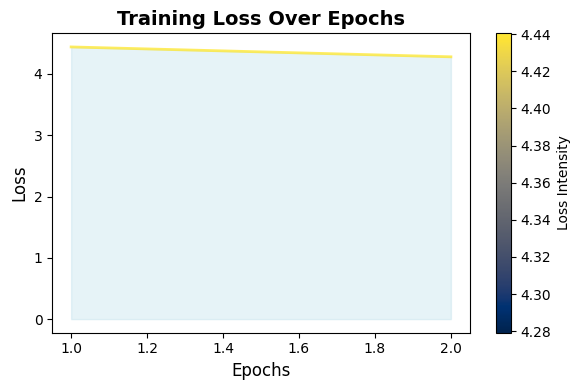

In [60]:
# english french model
train_cross_domain_non_parallel(
    encoder_model_1,
    decoder_model_1,
    disc_model_1,
    enc_dec_optimizer_1,
    disc_optimizer_1,
    source_loader1,
    target_loader1,
    source_vocab1,
    target_vocab1,
    source_to_target_mapping1,
    target_to_source_mapping1,
    clip=1.0,
)

torch.Size([2, 50, 100])
torch.Size([2, 50, 100])
torch.Size([2, 50, 1])
Epoch [1/2], Auto Loss (Source): 0.9965, Auto Loss (Target): 1.0307, Cross-Domain Loss (Source to Target): 0.9982, Cross-Domain Loss (Target to Source): 1.0243, Adv Loss: 1.4555, Total Loss: 4.5135
torch.Size([2, 50, 100])
torch.Size([2, 50, 100])
torch.Size([2, 50, 1])
Epoch [2/2], Auto Loss (Source): 0.9558, Auto Loss (Target): 0.9995, Cross-Domain Loss (Source to Target): 0.9595, Cross-Domain Loss (Target to Source): 0.9991, Adv Loss: 1.4552, Total Loss: 4.3783


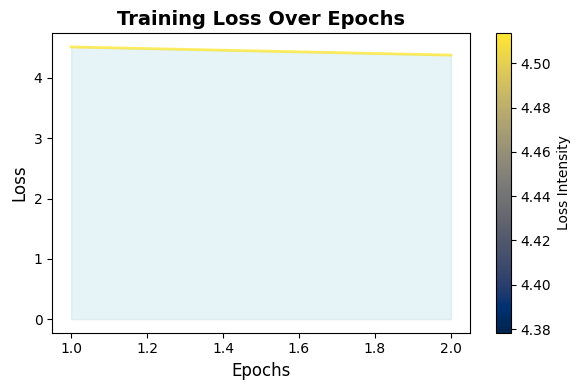

In [61]:
# english german model
train_cross_domain_non_parallel(
    encoder_model_2,
    decoder_model_2,
    disc_model_2,
    enc_dec_optimizer_2,
    disc_optimizer_2,
    source_loader2,
    target_loader2,
    source_vocab2,
    target_vocab2,
    source_to_target_mapping2,
    target_to_source_mapping2,
    clip=1.0,
)

torch.Size([2, 50, 100])
torch.Size([2, 50, 100])
torch.Size([2, 50, 1])
Epoch [1/2], Auto Loss (Source): 0.9736, Auto Loss (Target): 1.0233, Cross-Domain Loss (Source to Target): 0.9795, Cross-Domain Loss (Target to Source): 1.0243, Adv Loss: 1.4546, Total Loss: 4.4656
torch.Size([2, 50, 100])
torch.Size([2, 50, 100])
torch.Size([2, 50, 1])
Epoch [2/2], Auto Loss (Source): 0.9361, Auto Loss (Target): 0.9922, Cross-Domain Loss (Source to Target): 0.9412, Cross-Domain Loss (Target to Source): 0.9950, Adv Loss: 1.4540, Total Loss: 4.3299


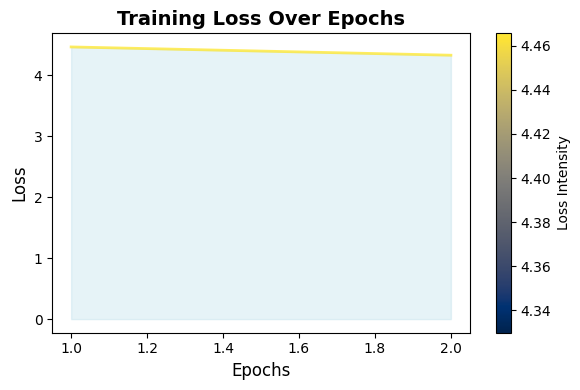

In [62]:
# french german model
train_cross_domain_non_parallel(
    encoder_model_3,
    decoder_model_3,
    disc_model_3,
    enc_dec_optimizer_3,
    disc_optimizer_3,
    source_loader3,
    target_loader3,
    source_vocab3,
    target_vocab3,
    source_to_target_mapping3,
    target_to_source_mapping3,
    clip=1.0,
)

In [63]:
def generate_cross_domain_text(df, encoder_model, decoder_model, tokenizer, vocab_embeddings, source_lang_idx, target_lang_idx):
    """
    Generate cross-domain sentences by encoding source sentences and decoding in the target domain.

    Args:
        df (DataFrame): DataFrame containing source sentences and their embeddings.
        encoder_model (nn.Module): Encoder model.
        decoder_model (nn.Module): Decoder model.
        tokenizer: Tokenizer for converting tokens to text.
        vocab_embeddings: Vocabulary embeddings for decoding.
        source_lang_idx (int): Language index for the source language.
        target_lang_idx (int): Language index for the target language.

    Returns:
        list of str: Generated sentences in the target language.
    """
    # Stack embeddings from DataFrame and set to device
    inputs = torch.stack([sentence for sentence in df['Embeddings']]).to(device)
    source_lang_tensor = torch.tensor([source_lang_idx] * len(df)).to(device)

    # Step 1: Encode input sentences in the source language
    encoder_outputs, latent_vectors = encoder_model(inputs, source_lang_tensor)

    # Initialize decoder hidden state for each batch in target language
    hidden = decoder_model.init_hidden(len(df['Embeddings']))
    target_lang_tensor = torch.tensor([target_lang_idx] * len(df)).to(device)

    # Step 2: Decode latent vectors in the target language
    outputs, hidden = decoder_model(latent_vectors, encoder_outputs, hidden, target_lang_tensor)

    # Step 3: Convert output embeddings to text using vocabulary embeddings
    generated_text = embeddings_to_text(outputs, tokenizer, vocab_embeddings)

    # Clean up special tokens from generated sentences
    def clean_output(text):
        return ' '.join(
            [token for token in text.split() if token not in [
                '[SEP]', '[SEP].', '[MASK]', '[CLS]'
            ]]
        )

    cleaned_text = [clean_output(sentence) for sentence in generated_text]

    # Print and return generated cross-domain sentences
    for sentence in cleaned_text:
        print("Generated Target Sentence:", sentence)

    return cleaned_text

In [64]:
# Example DataFrame with source domain embeddings
source_df = french_df 

# Source and target language indices
source_lang_idx = lang_idx_mapping['french']  
target_lang_idx = lang_idx_mapping['english']  

# Generate cross-domain sentences from English to French
generate_cross_domain_text(
    source_df,
    encoder_model_1,
    decoder_model_1,
    tokenizer_en,
    vocab_embeddings_en,
    source_lang_idx,
    target_lang_idx
)

Generated Target Sentence: award isbn role forgotten forgotten isbn isbn forgotten forgotten isbn role forgotten darkness abyss race award essential × isbn waiting role isbn isbn forgotten struggledmaker isbn forgotten waiting essential occupied forgotten isbn isbn isbn forgotten vacuumsia forgotten essential role essential isbn vacuum role isbn award isbn
Generated Target Sentence: award isbn role isbn isbn essential forgotten isbn role symbol isbn isbn forgotten isbn role elite forgotten isbn isbn award symbol award award character forgotten expansion abyss role isbn role award isbn waiting forgotten forgotten role role vacuum role forgotten forgotten award essential


['award isbn role forgotten forgotten isbn isbn forgotten forgotten isbn role forgotten darkness abyss race award essential × isbn waiting role isbn isbn forgotten struggledmaker isbn forgotten waiting essential occupied forgotten isbn isbn isbn forgotten vacuumsia forgotten essential role essential isbn vacuum role isbn award isbn',
 'award isbn role isbn isbn essential forgotten isbn role symbol isbn isbn forgotten isbn role elite forgotten isbn isbn award symbol award award character forgotten expansion abyss role isbn role award isbn waiting forgotten forgotten role role vacuum role forgotten forgotten award essential']

## Testing

### BLEU (Bilingual Evaluation Understudy) Score
BLEU is a precision-based metric used primarily for evaluating machine translation systems by comparing n-grams (sequences of n words) in the generated output to n-grams in the reference output.

- BLEU counts the number of n-grams (such as unigram, bigram, trigram, etc.) that overlap between the candidate translation (generated text) and one or more reference translations.

- It then computes the precision for each n-gram level (e.g., how many unigrams in the generated output appear in the reference output).

- To avoid the model outputting repetitive or trivial answers, a brevity penalty is applied to penalize translations that are too short.

In [65]:
# Load Parallel Dataset
sentences = []

with open('./Dataset/Parallel/fra-news-commentary-v18.txt', 'r', encoding='utf-8') as file:
    sentences = file.readlines()

    sentences = [sentence.strip() for sentence in sentences]
    french_parallel_df = pd.DataFrame(sentences, columns=['Sentence'])
    french_parallel_df

In [66]:
french_parallel_df

,Sentence
0,L’or à 10.000 dollars l’once ?
1,SAN FRANCISCO – Il n’a jamais été facile d’avo...
2,"Et aujourd’hui, alors que le cours de l’or a a..."
3,"En décembre dernier, mes collègues économistes..."
4,Mais devinez ce qui s’est passé ?
...,...
492325,Mais il semblerait cependant que cette générat...
492326,Dans une région qui révère les personnes âgées...
492327,"3 Sud-africains sur 10 ont moins de 15 ans, ce..."
492328,"D’une manière ou d’une autre, Zuma doit trouve..."


In [67]:
sentences = []

with open('./Dataset/Parallel/eng-news-commentary-v18.txt', 'r', encoding='utf-8') as file:
    sentences = file.readlines()

    sentences = [sentence.strip() for sentence in sentences]
    english_parallel_df = pd.DataFrame(sentences, columns=['Sentence'])
    english_parallel_df

In [68]:
english_parallel_df

,Sentence
0,"$10,000 Gold?"
1,SAN FRANCISCO – It has never been easy to have...
2,"Lately, with gold prices up more than 300% ove..."
3,"Just last December, fellow economists Martin F..."
4,Wouldn’t you know it?
...,...
901593,"At the same time, Zuma’s revolutionary generat..."
901594,"In a region that reveres the elderly, Zuma’s a..."
901595,Three in ten South Africans are younger than 1...
901596,Somehow Zuma must find a way to honor his own ...


In [69]:
sentences = []

with open('./Dataset/Parallel/german-news-commentary-v18.txt', 'r', encoding='utf-8') as file:
    sentences = file.readlines()

    sentences = [sentence.strip() for sentence in sentences]
    german_parallel_df = pd.DataFrame(sentences, columns=['Sentence'])
    german_parallel_df

In [70]:
german_parallel_df

,Sentence
0,Steigt Gold auf 10.000 Dollar?
1,"SAN FRANCISCO – Es war noch nie leicht, ein ra..."
2,In letzter Zeit allerdings ist dies schwierige...
3,Erst letzten Dezember verfassten meine Kollege...
4,"Und es kam, wie es kommen musste."
...,...
520173,Gleichzeitig scheint sich Zumas revolutionäre ...
520174,"In einer Region, wo die älteren Menschen sehr ..."
520175,Drei von zehn Südafrikanern sind jünger als 15...
520176,"Irgendwie muss Zuma einen Weg finden, einersei..."


In [71]:
x = 100
french_parallel_df = french_parallel_df[:x]
english_parallel_df = english_parallel_df[:x]
german_parallel_df = german_parallel_df[:x]

In [72]:
# Remove empty sentences if any
english_parallel_df = english_parallel_df[english_parallel_df['Sentence'].notna() & (english_parallel_df['Sentence'] != '')]
french_parallel_df = french_parallel_df[french_parallel_df['Sentence'].notna() & (french_parallel_df['Sentence'] != '')]
german_parallel_df = german_parallel_df[german_parallel_df['Sentence'].notna() & (german_parallel_df['Sentence'] != '')]

In [73]:
english_parallel_df.loc[:, 'Sentence'] = english_parallel_df['Sentence'].apply(lambda x: preprocess_text(x))
french_parallel_df.loc[:, 'Sentence'] = french_parallel_df['Sentence'].apply(lambda x: preprocess_text(x))
german_parallel_df.loc[:, 'Sentence'] = german_parallel_df['Sentence'].apply(lambda x: preprocess_text(x))

In [74]:
# Tokenize
english_parallel_df['Tokens'] = english_parallel_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_en))
french_parallel_df['Tokens'] = french_parallel_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_fr))
german_parallel_df['Tokens'] = german_parallel_df['Sentence'].apply(lambda x: tokenize_with_spacy(x, nlp_fr))

In [75]:
# Drop sentences longer than 50 words
english_parallel_df = english_parallel_df[english_parallel_df['Tokens'].apply(len) <= MAX_SEQ_LEN]
french_parallel_df = french_parallel_df[french_parallel_df['Tokens'].apply(len) <= MAX_SEQ_LEN]
german_parallel_df = german_parallel_df[german_parallel_df['Tokens'].apply(len) <= MAX_SEQ_LEN]

In [76]:
english_parallel_embeddings = generate_embeddings(english_parallel_df, tokenizer_en, bert_model_en)
english_parallel_embeddings[0].shape

torch.Size([2, 768])

In [77]:
generate_padded_embeddings(english_parallel_df, english_parallel_embeddings)

Padded Embeddings Shape: torch.Size([98, 50, 768])


In [78]:
french_parallel_embeddings = generate_embeddings(french_parallel_df, tokenizer_fr, bert_model_fr)
french_parallel_embeddings[0].shape

torch.Size([5, 768])

In [79]:
generate_padded_embeddings(french_parallel_df, french_parallel_embeddings)

Padded Embeddings Shape: torch.Size([97, 50, 768])


In [80]:
german_parallel_embeddings = generate_embeddings(german_parallel_df, tokenizer_de, bert_model_de)
german_parallel_embeddings[0].shape

torch.Size([5, 768])

In [81]:
generate_padded_embeddings(german_parallel_df, german_parallel_embeddings)

Padded Embeddings Shape: torch.Size([97, 50, 768])


In [82]:
# Find the minimum length across all three datasets
min_length = min(len(english_parallel_df), len(french_parallel_df), len(german_parallel_df))

# Slice each dataset to the minimum length
english_parallel_df = english_parallel_df.iloc[:min_length]
french_parallel_df = french_parallel_df.iloc[:min_length]
german_parallel_df = german_parallel_df.iloc[:min_length]

In [83]:
# Function for evaluation
def evaluate_translation(df, hypothesis, nlp):
    tokenized_hypotheses = [list(map(str, nlp(sentence))) for sentence in hypothesis]
    references = [[sentence] for sentence in df['Tokens']]  # 2D array
    bleu_score = corpus_bleu(references, tokenized_hypotheses)
    print(f'---BLEU Score: {bleu_score}---')

    ter_scorer = TER()
    references = [sentence for sentence in df['Sentence']]
    ter_score = ter_scorer.corpus_score(hypothesis, references)
    print(f'---TER Score: {ter_score}---')

    return bleu_score, ter_score

In [84]:
english_parallel_df.head()

,Sentence,Tokens,Embeddings
0,10000 gold,"[10000, gold]","[[tensor(0.1158), tensor(0.5598), tensor(-0.16..."
1,san francisco it has never been easy to have ...,"[san, francisco, it, has, never, been, easy, ...","[[tensor(0.0223), tensor(0.5831), tensor(-0.47..."
2,lately with gold prices up more than 300 over ...,"[lately, with, gold, prices, up, more, than, 3...","[[tensor(-0.0189), tensor(-0.1453), tensor(0.1..."
3,just last december fellow economists martin fe...,"[just, last, december, fellow, economists, mar...","[[tensor(-0.1602), tensor(-0.6915), tensor(-0...."
4,wouldnt you know it,"[wouldnt, you, know, it]","[[tensor(0.2585), tensor(0.1241), tensor(-0.04..."


In [85]:
french_parallel_df.head()

,Sentence,Tokens,Embeddings
0,lor à 10000 dollars lonce,"[lor, à, 10000, dollars, lonce]","[[tensor(0.1216), tensor(0.0036), tensor(-0.10..."
1,san francisco il na jamais été facile davoir ...,"[san, francisco, il, na, jamais, été, facile,...","[[tensor(0.0807), tensor(0.0740), tensor(-0.14..."
2,et aujourdhui alors que le cours de lor a augm...,"[et, aujourdhui, alors, que, le, cours, de, lo...","[[tensor(0.0069), tensor(0.4622), tensor(-0.13..."
3,en décembre dernier mes collègues économistes ...,"[en, décembre, dernier, mes, collègues, économ...","[[tensor(0.0339), tensor(0.0724), tensor(0.015..."
4,mais devinez ce qui sest passé,"[mais, devinez, ce, qui, sest, passé]","[[tensor(0.0690), tensor(0.1783), tensor(0.181..."


### English to French

In [86]:
source_df = english_parallel_df 

# Source and target language indices
source_lang_idx = lang_idx_mapping['english']  
target_lang_idx = lang_idx_mapping['french']  

# Generate cross-domain sentences from English to French
french_hypothesis = generate_cross_domain_text(
    source_df,
    encoder_model_1,
    decoder_model_1,
    tokenizer_fr,
    vocab_embeddings_fr,
    source_lang_idx,
    target_lang_idx
)

evaluate_translation(french_parallel_df, french_hypothesis, nlp_fr)

Generated Target Sentence: House journaux House House journaux House Houseégu gars House crever siège table table House House table table House House table House House table House House table Houseégu table lits table House journaux House House table TransfertFloESP House Houseégu House House journaux table table séminaire table
Generated Target Sentence: journaux table House journaux House siège House House House House House House séminaireCl Transfert House table table House House tombeau table House House House House House House HouseACT table House table House House House House House journauxégu House Houseégu table tableégu House House Table journal
Generated Target Sentence: journaux Houseégu Houseégu House House table table House table poster table House House House table lits table House table House House House House tableégu table table table House House House tableégu House House House House House journaux House House table journaux House House journaux table House
Generated 

(0, TER = 5239.28)

### French to English

In [87]:
# French to English
source_df = french_parallel_df 

# Source and target language indices
source_lang_idx = lang_idx_mapping['french']  
target_lang_idx = lang_idx_mapping['english']  

# Generate cross-domain sentences from French to English
english_hypothesis = generate_cross_domain_text(
    source_df,
    encoder_model_1,
    decoder_model_1,
    tokenizer_en,
    vocab_embeddings_en,
    source_lang_idx,
    target_lang_idx
)

evaluate_translation(english_parallel_df, english_hypothesis, nlp_en)

Generated Target Sentence: award award essential isbn waiting expansion role award isbn isbn isbn isbn expansion isbn role symbol essentialmaker isbn award role isbn award isbn award forgotten role isbn race award vacuum operating forgotten isbn role role role symbol isbn forgotten forgotten isbn rolemaker isbn role role isbn
Generated Target Sentence: award award award award role forgotten expansion isbn forgotten vacuum forgotten expansion role role isbn forgotten isbn isbn isbnmaker abyss isbn role award isbn role isbn isbn winner elite forgotten role isbn role isbn award isbn symbol essential isbn award forgotten isbn awardmaker vacuum isbn
Generated Target Sentence: role award forgotten forgotten forgotten secret waiting isbn role role everythingmaker area abyss forgotten isbn award isbn isbn isbn isbn expansion symbol operating forgotten isbn award role isbn priority essential essential isbn essential essential forgotten elite role area role isbn forgotten winner rolemaker isbn i

(2.925474820467109e-232, TER = 5507.63)

### English to German

In [88]:
# English to German
source_df = english_parallel_df

# Source and target language indices
source_lang_idx = lang_idx_mapping['english']  
target_lang_idx = lang_idx_mapping['german']  

# Generate cross-domain sentences from English to German
german_hypothesis = generate_cross_domain_text(
    source_df,
    encoder_model_2,
    decoder_model_2,
    tokenizer_de,
    vocab_embeddings_de,
    source_lang_idx,
    target_lang_idx
)

evaluate_translation(german_parallel_df, german_hypothesis, nlp_de)

Generated Target Sentence: ##istin Sitten Artsistin Artsährung körperlichenährung8) Arts körperlichen Sitten körperlichenährung Töchteristinistin körperlichenvitistin Sitten körperlichenfechtfechtmodelleistin Sitten Bewertungenährungistin Sitten Bewertungen Sitten Sitten körperlicheistin Laub Venezuelafecht Sitten Sittenfecht Töchter Män Sitten Sitten8) körperlichen verbringenunterhalt
Generated Target Sentence: ##istin Sitten Sittenistinerk Sitten Artsistinistin Sitten Sittenährungaufnahmenährung Sitten Töchter Betreiber Bewertungen Sitten Artsfecht Betreibervit körperlichestellbar körperlicheistinährungistin körperlichen Bewertungen Betreiber Bewertungen Artsfecht Sitten Töchter Sittenerk körperlichen körperlichefecht Bewertungenährung Sitten Arts Sitten Töchter Artsfecht
Generated Target Sentence: Sitten Bewertungen Sitten Sitten Sitten Sitten Sitten Arts Sittenfecht Behandlungährung Töchter Sitten Sittenährung Sittenistin Sittenährungvitfecht Arts Pazifik Töchter Aufnahmen Aufnahme

(0, TER = 3583.70)

### German to English

In [89]:
# German to English
source_df = german_parallel_df

# Source and target language indices
source_lang_idx = lang_idx_mapping['german']  
target_lang_idx = lang_idx_mapping['english']  

# Generate cross-domain sentences from French to French
english_hypothesis = generate_cross_domain_text(
    source_df,
    encoder_model_2,
    decoder_model_2,
    tokenizer_en,
    vocab_embeddings_en,
    source_lang_idx,
    target_lang_idx
)

evaluate_translation(english_parallel_df, english_hypothesis, nlp_en)

Generated Target Sentence: ##raderaderaderaderade as becomeraderaderaderade seerade as as commentingraderadefield olympiaraderadetickradefieldraderaderaderaderaderaderade pas towardsfieldradefieldraderaderadetickraderaderadefielddick towardsfieldraderade
Generated Target Sentence: ##raderaderaderaderaderaderaderaderade renamedrade towardsdickfieldraderaderaderaderaderaderade pas asraderaderaderaderaderaderaderaderade sent alternativeraderaderaderaderaderaderaderaderaderaderaderaderaderaderade teammate
Generated Target Sentence: ##raderaderadetickradetickraderadedickraderaderaderasraderaderaderaderadefieldraderaderaderaderaderaderadefield myfieldradefieldfield commentingfield foxrade towardsrade asrade my towardsrade asfield titledraderadetagramrade
Generated Target Sentence: ##raderaderaderaderaderaderaderade sisraderade towards epsraderade myraderade exceptrade pasdickrade towardstickrade olympia asraderade hmsradefieldrade becomeraderaderadefield newfoundradefieldradetickfield newfou

(1.6152724189471346e-232, TER = 1174.33)

### French to German

In [90]:
# French to German
source_df = french_parallel_df

# Source and target language indices
source_lang_idx = lang_idx_mapping['french']  
target_lang_idx = lang_idx_mapping['german']  

# Generate cross-domain sentences from French to French
german_hypothesis = generate_cross_domain_text(
    source_df,
    encoder_model_3,
    decoder_model_3,
    tokenizer_de,
    vocab_embeddings_de,
    source_lang_idx,
    target_lang_idx
)

evaluate_translation(german_parallel_df, german_hypothesis, nlp_de)

Generated Target Sentence: Mietvertrag Kaufvertrag Mietvertrag Mietvertrag Mietvertrag Umzug Wiesn Mietvertrag Schulden Mietvertrag Mietvertrag Mietvertrag Mietvertrag Mietvertrag Mietvertrag Mietvertrag Mietvertrag Schulden Wiesn Mietvertrag Mietvertrag Schulden Wiesn Schulden Malt Dienstes Anm hierzulande spielen Mietvertrag Schulden hierzulande hierzulande Abkommen Schulden Wulff Mietvertrag Schulden Mietvertrag Mietvertrag Schulden Abkommen Mietvertrag Abkommen Schulden Mietvertrag Abkommen spielen Schulden Mietvertrag
Generated Target Sentence: jetz Mietvertrag Schulden Definition Mietvertrag Mietvertrag hierzulande Engl Mietvertrag Schulden Mietvertrag Mietvertrag Mietvertrag Mietvertrag Maut hierzulande Konsum Mietvertrag hierzulande Schulden Mietvertrag investiert Mietvertrag Mietvertrag Abkommen Mietvertrag Umzug Abkommen Mietvertrag Konsum Definition Mietvertrag Invest Schulden bay Kaufvertrag Mietvertrag bedeckt journal Mietvertrag Mietvertrag Mietvertrag Kommun Spiels Malt 

(0, TER = 5768.69)

### German to French

In [91]:
# German to French
source_df = german_parallel_df

# Source and target language indices
source_lang_idx = lang_idx_mapping['german']  
target_lang_idx = lang_idx_mapping['french']  

# Generate cross-domain sentences from French to French
french_hypothesis = generate_cross_domain_text(
    source_df,
    encoder_model_3,
    decoder_model_3,
    tokenizer_fr,
    vocab_embeddings_fr,
    source_lang_idx,
    target_lang_idx
)

evaluate_translation(french_parallel_df, french_hypothesis, nlp_fr)

Generated Target Sentence: déposé neutre neutre neutre 2019 neutre final prochaine chaque final futur chaque 100 différente établie recherche neutre nouvelle final final différente Fr final établie final établie recherche final futur cela final final chaque établi différente chaque final santé prochaine recherche différente 100 différente chaque final prochaine neutre futur recherche final
Generated Target Sentence: final final prochain établie futur TR 100 final différente neutre neutre général futur établie futur prochaine recherche établie final différente final générale final 100 100 chaque R chacun futur remplacer recherche différente futur établi établi final futur recherche final final prochaine style établie neutre différente base propre troisième X futur
Generated Target Sentence: rendu négative futur final général forme final futur prochaine libre recherche chaque chaque 100 général futur établie libre santé modèle recherche 100 chaque chaque recherche établie générale final 

(4.070986569878416e-232, TER = 5898.77)